# Import libraries

In [22]:
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import cv2
import os
import random
import matplotlib.pyplot as plt
from torch.nn.functional import one_hot

from src.metrics import *
from src.utils import *
from src.datasets import ExcavatorDataset
from src.config import TRANSFORMER, ROOT, DEVICE
from models.Segmentation import DeepLabV3Model, DeepLabV3PlusModel, PyramidAttentionNetworkModel, UNetModel

# Load dataset

In [23]:
train_dataset = ExcavatorDataset(return_type='image+mask+path', purpose='train', plot=False)
print("Number of train imgs: ", len(train_dataset))
val_dataset = ExcavatorDataset(return_type='image+mask+path', purpose='validation', plot=False)
print("Number of val imgs: ", len(val_dataset))
cls_colors = train_dataset.class_colors

Number of train imgs:  1782
Number of val imgs:  187


C:\Users\vunha\Documents\Uni_Infos\Bachelorarbeit\workspace\similarity_metrics_of_images\src\datasets.py:313: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(value / 255.0, dtype=torch.float32)


# Test 1. VLAD (PASS)

In [21]:
for i in range(30):
    num_cls= np.random.choice([32, 64, 128, 256])
    feature = np.random.choice(['sift', 'root_sift'])
    dataset_choice = np.random.choice(['train', 'validation'])
    if dataset_choice == 'train':
        dataset = train_dataset
    else:
        dataset = val_dataset
    print("Chosen dataset:", dataset_choice)
    idx_1 = 0
    idx_2 = 0
    while idx_1 == idx_2:
        idx_1 = random.randint(0, len(dataset)-1)
        idx_2 = random.randint(0, len(dataset)-1)

    image_1, *_ ,path1= dataset[idx_1]
    image_2, *_, path2 = dataset[idx_2]
    k_means = load_model(f'{ROOT}/models/pickle_model_files/k_means_model_k{num_cls}_{feature}.pkl')

    vlad_1 = VLAD(image_1, k_means=k_means, flatten=True, feature=feature, verbose=False).vector
    print("Length of VLAD vector:", len(vlad_1))
    vlad_2 = VLAD(image_2, k_means=k_means, flatten=True, feature=feature, verbose=False).vector
    print("Length of VLAD vector:", len(vlad_2))

    print("VLAD cosine similarity:", res:=cosine_similarity(vlad_1.reshape(1, -1), vlad_2.reshape(1, -1))[0][0])

    hdf_file = load_hdf5(f'{ROOT}/res/vlad/{dataset_choice}/k_means_model_k{num_cls}_{feature}.h5')

    vlad_check_1 = hdf_file[os.path.basename(path1)]
    vlad_check_2 = hdf_file[os.path.basename(path2)]
    print("Check VLAD cosine similarity:", res_check:=cosine_similarity(vlad_check_1.reshape(1, -1), vlad_check_2.reshape(1, -1))[0][0])
    if not abs(res - res_check) < 1e-5:
        raise ValueError("VLAD cosine similarity is not equal to the check value")

Chosen dataset: validation
Length of VLAD vector: 16384
Length of VLAD vector: 16384
VLAD cosine similarity: 0.03336356636658923
Check VLAD cosine similarity: 0.03336356636658923
Chosen dataset: train
Length of VLAD vector: 4096
Length of VLAD vector: 4096
VLAD cosine similarity: -0.13264337908094467
Check VLAD cosine similarity: -0.13264352853082212
Chosen dataset: train
Length of VLAD vector: 32768
Length of VLAD vector: 32768
VLAD cosine similarity: -0.011288718661156312
Check VLAD cosine similarity: -0.01128854262651461
Chosen dataset: train
Length of VLAD vector: 8192
Length of VLAD vector: 8192
VLAD cosine similarity: 0.06098375852029178
Check VLAD cosine similarity: 0.060985150868467876
Chosen dataset: validation
Length of VLAD vector: 16384
Length of VLAD vector: 16384
VLAD cosine similarity: 0.058442238357727175
Check VLAD cosine similarity: 0.05844112528071653
Chosen dataset: validation
Length of VLAD vector: 32768
Length of VLAD vector: 32768
VLAD cosine similarity: 0.006041

# 2. Fisher Vector (PASS)

In [19]:
for i in range(30):
    num_cls= np.random.choice([32, 64, 128, 256])
    feature = np.random.choice(['sift', 'root_sift'])
    dataset_choice = np.random.choice(['train', 'validation'])
    if dataset_choice == 'train':
        dataset = train_dataset
    else:
        dataset = val_dataset
    print("Chosen dataset:", dataset_choice)
    idx_1 = 0
    idx_2 = 0
    while idx_1 == idx_2:
        idx_1 = random.randint(0, len(dataset)-1)
        idx_2 = random.randint(0, len(dataset)-1)

    image_1, *_ ,path1= dataset[idx_1]
    image_2, *_, path2 = dataset[idx_2]
    gmm = load_model(f'{ROOT}/models/pickle_model_files/gmm_model_k{num_cls}_{feature}.pkl')

    fisher_1 = FisherVector(image_1, gmm=gmm, flatten=True, feature=feature, verbose=False).vector
    print("Length of VLAD vector:", len(fisher_1))
    fisher_2 = FisherVector(image_2, gmm=gmm, flatten=True, feature=feature, verbose=False).vector
    print("Length of VLAD vector:", len(fisher_2))

    print("Fisher cosine similarity:", res:=cosine_similarity(fisher_1.reshape(1, -1), fisher_2.reshape(1, -1))[0][0])

    hdf_file = load_hdf5(f'{ROOT}/res/fisher/{dataset_choice}/gmm_model_k{num_cls}_{feature}.h5')

    fisher_check_1 = hdf_file[os.path.basename(path1)]
    fisher_check_2 = hdf_file[os.path.basename(path2)]
    print("Check Fisher cosine similarity:", res_check:=cosine_similarity(fisher_check_1.reshape(1, -1), fisher_check_2.reshape(1, -1))[0][0])
    if not abs(res - res_check) < 1e-5:
        raise ValueError("Fisher cosine similarity is not equal to the check value")


Chosen dataset: train
Length of VLAD vector: 65792
Length of VLAD vector: 65792
Fisher cosine similarity: 0.004980870439030221
Check Fisher cosine similarity: 0.004980365299849838
Chosen dataset: train
Length of VLAD vector: 32896
Length of VLAD vector: 32896
Fisher cosine similarity: 0.001700460873774351
Check Fisher cosine similarity: 0.0016999784068775698
Chosen dataset: train
Length of VLAD vector: 16448
Length of VLAD vector: 16448
Fisher cosine similarity: 0.04328881610171781
Check Fisher cosine similarity: 0.04328904693809324
Chosen dataset: train
Length of VLAD vector: 65792
Length of VLAD vector: 65792
Fisher cosine similarity: -0.009151578372894579
Check Fisher cosine similarity: -0.009149023310997578
Chosen dataset: validation
Length of VLAD vector: 65792
Length of VLAD vector: 65792
Fisher cosine similarity: 0.02698540727884435
Check Fisher cosine similarity: 0.02698619601236898
Chosen dataset: train
Length of VLAD vector: 8224
Length of VLAD vector: 8224
Fisher cosine simi

# 3. SSIM

In [5]:
for i in range(30):
    idx_1 = 0
    idx_2 = 0
    while idx_1 == idx_2:
        idx_1 = random.randint(0, len(train_dataset)-1)
        idx_2 = random.randint(0, len(train_dataset)-1)

    sigma = np.random.choice([2, 6, 10, 14 ,18])

    image_1, *_ ,path1= train_dataset[idx_1]
    print(path1)
    image_2, *_, path2 = train_dataset[idx_2]

    image_1 = TRANSFORMER(image_1)
    image_2 = TRANSFORMER(image_2)

    image_1 = gaussian_blur(image_1, sigma=sigma, kernel_size = 2*int(3*sigma)+1)
    image_2 = gaussian_blur(image_2, sigma=sigma, kernel_size = 2*int(3*sigma)+1)

    ssim = SSIM(image_1, image_2)
    ms_ssim = MS_SSIM(image_1, image_2)
    print("SSIM:", res_ssim:=ssim.value.numpy())
    print("MS-SSIM:", res_ms_ssim:=ms_ssim.value.numpy())

    hdf_file = load_hdf5(f'{ROOT}/res/ssim/ssim_sigma{sigma}.h5')

    # SSIm results were only saved in the upper triangular part of the matrix. Make it symmetric
    hdf_file['ssim'] = hdf_file['ssim'].T + hdf_file['ssim'] + np.eye(len(train_dataset), len(train_dataset))
    hdf_file['ms_ssim'] = hdf_file['ms_ssim'].T + hdf_file['ms_ssim'] + np.eye(len(train_dataset), len(train_dataset))

    path_1_check = None
    idx_arr_1 = None
    path_2_check = None
    idx_arr_2 = None

    for i, path in enumerate(hdf_file['image_paths']):
        if isinstance(path, bytes):
            path = path.decode('utf-8')
        path = path.replace('|', '/')
        if os.path.basename(path1) == os.path.basename(path):
            path_1_check = path.replace('/', '|')
            idx_arr_1 = i
        if os.path.basename(path2) == os.path.basename(path):
            path_2_check = path.replace('/', '|')
            idx_arr_2 = i

    ssim_check = hdf_file['ssim'][idx_arr_2]
    ms_ssim_check = hdf_file['ms_ssim'][idx_arr_2]
    print("Check SSIM:", ssim_res_check:=ssim_check[idx_arr_1])
    print("Check MS-SSIM:", ms_ssim_res_check:=ms_ssim_check[idx_arr_1])
    if not abs(res_ssim - ssim_res_check) < 1e-5:
       raise ValueError("SSIM is not equal to the check value")
    if not abs(res_ms_ssim - ms_ssim_res_check) < 1e-5:
         raise ValueError("MS-SSIM is not equal to the check value")

D:\bachelor_thesis\excavator_dataset_w_masks\train\truck\002677_jpg.rf.4749cd2644bb310ec5df33d49cfca511.jpg
SSIM: 0.40192512
MS-SSIM: 0.29042327
dict_keys(['image_paths', 'ms_ssim', 'ssim'])
Check SSIM: 0.40192532539367676
Check MS-SSIM: 0.2904234528541565
D:\bachelor_thesis\excavator_dataset_w_masks\train\truck\3b73d0bf347e7e753cdc16fe543efbc5_jpg.rf.0f10a7c51f33a3a30334861b8c64d313.jpg
SSIM: 0.43443668
MS-SSIM: 0.33081123
dict_keys(['image_paths', 'ms_ssim', 'ssim'])
Check SSIM: 0.4344373941421509
Check MS-SSIM: 0.3308117091655731
D:\bachelor_thesis\excavator_dataset_w_masks\train\truck\8f995eb74c652c1fa30741a666664046_jpg.rf.56fa9c476412786493048fdd73c293bd.jpg
SSIM: 0.30967477
MS-SSIM: 0.18801554
dict_keys(['image_paths', 'ms_ssim', 'ssim'])
Check SSIM: 0.30967503786087036
Check MS-SSIM: 0.18801574409008026
D:\bachelor_thesis\excavator_dataset_w_masks\train\caterpillar\002748_jpg.rf.e969199fd66efd0d4d583f645f48ee87.jpg
SSIM: 0.6882651
MS-SSIM: 0.5003666
dict_keys(['image_paths', 'm

# 4. Model predictions

In [3]:
# DeepLabV3
dlv3 =DeepLabV3Model(model_path=f'{ROOT}/models/torch_model_files/DeepLabV3_HybridFocalDiceLoss.pt')

# DeepLabV3Plus
dlv3p = DeepLabV3PlusModel(model_path=f'{ROOT}/models/torch_model_files/DeepLabV3Plus_HybridFocalDiceLoss.pt')

# UNet
unet = UNetModel(model_path=f'{ROOT}/models/torch_model_files/UNet_HybridFocalDiceLoss.pt')

# Pyramid Attention Network
pan = PyramidAttentionNetworkModel(model_path=f'{ROOT}/models/torch_model_files/PyramidAttentionNetwork_HybridFocalDiceLoss.pt')

2024-12-08 09:38:03,533 - DeepLabV3 - INFO - Device used for model: cuda
2024-12-08 09:38:03,982 - DeepLabV3Plus - INFO - Device used for model: cuda
2024-12-08 09:38:04,480 - UNet - INFO - Device used for model: cuda
2024-12-08 09:38:04,909 - PyramidAttentionNetwork - INFO - Device used for model: cuda



a) IoU

Chosen model: PAN
Chosen image for training: D:\bachelor_thesis\excavator_dataset_w_masks\train\caterpillar\002777_jpg.rf.2ed41781ffb19f3536358b1215eededb.jpg. IoU: 0.8541939854621887
Chosen image for validation: D:\bachelor_thesis\excavator_dataset_w_masks\validation\truck\f9669e8fe2bd40e1ba0708aa9ff61b4e_jpg.rf.3a3982c6e50dc35a776655cb25eec7c1.jpg. IoU: 0.8755179643630981
IoU difference: tensor(-0.0213)


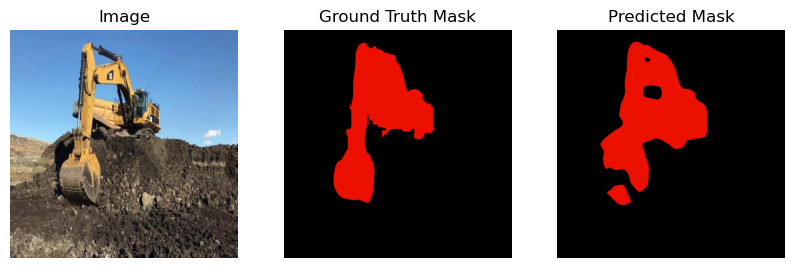

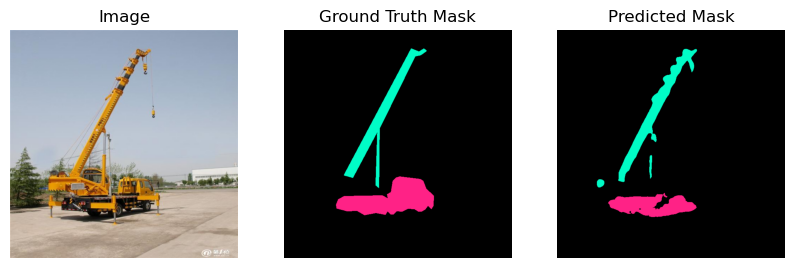

Chosen model: PAN
Chosen image for training: D:\bachelor_thesis\excavator_dataset_w_masks\train\excavator\a14_mp4-5_jpg.rf.3b0791f56d099e6f8811ab8d89aafd11.jpg. IoU: 0.6748965978622437
Chosen image for validation: D:\bachelor_thesis\excavator_dataset_w_masks\validation\truck\002745_jpg.rf.b8a5f4fd62311d5c80d119a16c687648.jpg. IoU: 0.5522065758705139
IoU difference: tensor(0.1227)


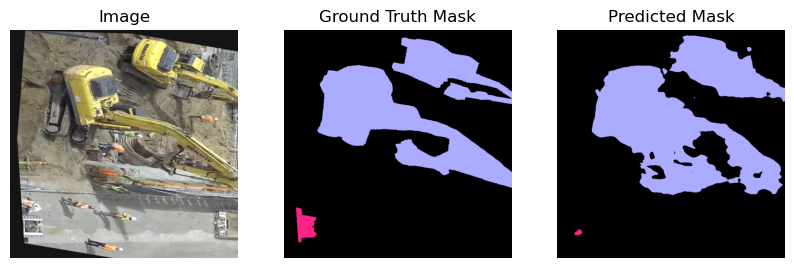

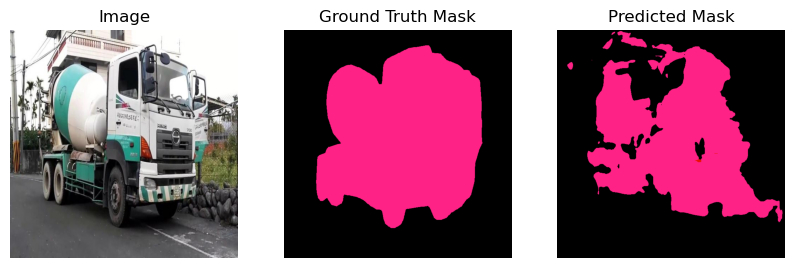

In [6]:
def plot_image_and_mask(image: torch.Tensor, gt_mask: torch.Tensor, pred_mask: torch.Tensor=None):
    """
    Plot image, ground truth mask and predicted mask (if available).

    :param image:
    :param gt_mask:
    :param pred_mask:
    :return:
    """
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    if image.shape[0] == 3:
        image = image.permute(1, 2, 0)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Image')
    plt.subplot(1, 3, 2)
    if gt_mask.shape[0] == 3:
        gt_mask = gt_mask.permute(1, 2, 0)
    plt.imshow(gt_mask)
    plt.axis('off')
    plt.title('Ground Truth Mask')

    if pred_mask is None:
        plt.show()
        return

    plt.subplot(1, 3, 3)
    if pred_mask.shape[0] == 3:
        pred_mask = pred_mask.permute(1, 2, 0)
    plt.imshow(pred_mask)
    plt.axis('off')
    plt.title('Predicted Mask')
    plt.show()

for i in range(2):
    idx = random.randint(0, len(train_dataset)-1)
    model = np.random.choice([dlv3, dlv3p, unet, pan])
    print("Chosen model:", model.model.__class__.__name__)

    dataset_choice = np.random.choice(['train', 'validation'])
    if dataset_choice == 'train':
        dataset = train_dataset
    else:
        dataset = val_dataset

    image, mask, path = dataset[idx]

    image = TRANSFORMER(image)

    mask = TRANSFORMER(mask)
    mask = rgb_to_mask(mask, cls_colors)


    _, pred_mask = model.predict_single_image(image, mask, raw_output=False)

    _, raw_pred= model.predict_single_image(image, mask, raw_output=True)
    mask_train_one_hot = one_hot(mask, num_classes=12).permute(2, 0, 1)
    iou_train = multiclass_iou(mask_train_one_hot, raw_pred)

    model_paths = {
        dlv3: f'{ROOT}/res/model_performance/iou_diff_dlv3.h5',
        dlv3p: f'{ROOT}/res/model_performance/iou_diff_dlv3p.h5',
        unet: f'{ROOT}/res/model_performance/iou_diff_unet.h5',
        pan: f'{ROOT}/res/model_performance/iou_diff_pan.h5'
    }

    iou_data = load_hdf5(model_paths[model])
    iou_diff, path_pairs = iou_data['iou_diff'], iou_data['path_pairs']

    pair_index = np.where(np.all(path_pairs == np.array([path_train, path_val]), axis=1))[0]
    iou_target = iou_diff[pair_index]
    print("Check IoU difference:", iou_target)

    if not abs(iou_diff_manual - iou_target) < 1e-5:
        raise ValueError("IoU difference is not equal to the check value")

    plot_image_and_mask(image_train, mask_to_rgb(mask_train, cls_colors), mask_to_rgb(pred_mask_train, cls_colors))
    plot_image_and_mask(image_val, mask_to_rgb(mask_val, cls_colors), mask_to_rgb(pred_mask_val, cls_colors))

In [24]:
data = load_hdf5(f'{ROOT}/res/model_performance/iou_diff_dlv3.h5')
data

{'iou_diff': array([-0.04079041, -0.05039352,  0.00846782, ...,  0.00372359,
         0.02575058,  0.02742949], dtype=float32),
 'path_pairs': array([[b'|home|ais|Bachelorarbeit|similarity_metrics_of_images|excavator_dataset_w_masks|train|caterpillar|002742_jpg.rf.91f9fde6c6c99e1dc69622e9a49f856c.jpg',
         b'|home|ais|Bachelorarbeit|similarity_metrics_of_images|excavator_dataset_w_masks|validation|caterpillar|002769_jpg.rf.92d80a592faeea9ab8380d67381a183d.jpg'],
        [b'|home|ais|Bachelorarbeit|similarity_metrics_of_images|excavator_dataset_w_masks|train|caterpillar|002742_jpg.rf.91f9fde6c6c99e1dc69622e9a49f856c.jpg',
         b'|home|ais|Bachelorarbeit|similarity_metrics_of_images|excavator_dataset_w_masks|validation|caterpillar|frame_4470_jpg.rf.be4bb516f3c83079c697c26eecababd2.jpg'],
        [b'|home|ais|Bachelorarbeit|similarity_metrics_of_images|excavator_dataset_w_masks|train|caterpillar|002742_jpg.rf.91f9fde6c6c99e1dc69622e9a49f856c.jpg',
         b'|home|ais|Bachelorarb

In [70]:

target = np.array([
    b"|home|ais|Bachelorarbeit|similarity_metrics_of_images|excavator_dataset_w_masks|train|truck|a11_mp4-6_jpg.rf.b7ae5c426ae502e142537a1f5df94caa.jpg",
    b'|home|ais|Bachelorarbeit|similarity_metrics_of_images|excavator_dataset_w_masks|validation|caterpillar|002831_jpg.rf.6cd9cbeb3f3b4ee03e6afd1ad5638f64.jpg'
])
row_index = np.where(np.all(data['path_pairs'] == target, axis=1))[0]
iou = data['iou_diff'][row_index]
iou

array([0.09984219], dtype=float32)